In [1]:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb

In [2]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf

In [3]:
tf.enable_eager_execution()

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
import unicodedata
import re
import numpy as np
import os
import time

In [6]:
tf.__version__

'1.10.0'

In [7]:
!ls

bin
etc
Exploring.ipynb
GAN with Keras.ipynb
include
lib
lib64
mnist
mnist_100.png
mnist_50.png
mnist.png
my_module.py
Neural_Machine_Translation_with_Attention_TensorFlow .ipynb
NeuralStyle
pip-selfcheck.json
pt2.py
pt3.py
pt.py
__pycache__
pyvenv.cfg
share
training_checkpoints
TransferLearningTutorialPytorch
Untitled1.ipynb
Untitled.ipynb
using_module.py


In [8]:
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://download.tensorflow.org/data/spa-eng.zip', extract=True)

In [9]:
!ls | grep 'eng'

In [10]:
!ls

bin
etc
Exploring.ipynb
GAN with Keras.ipynb
include
lib
lib64
mnist
mnist_100.png
mnist_50.png
mnist.png
my_module.py
Neural_Machine_Translation_with_Attention_TensorFlow .ipynb
NeuralStyle
pip-selfcheck.json
pt2.py
pt3.py
pt.py
__pycache__
pyvenv.cfg
share
training_checkpoints
TransferLearningTutorialPytorch
Untitled1.ipynb
Untitled.ipynb
using_module.py


In [11]:
path_to_zip

'/home/ivan/.keras/datasets/spa-eng.zip'

In [12]:
path_to_file = os.path.dirname(path_to_zip) + '/spa-eng/spa.txt'

In [13]:
path_to_file

'/home/ivan/.keras/datasets/spa-eng/spa.txt'

In [14]:
!ls -all /home/ivan/.keras/datasets/

total 2592
drwxrwxr-x 3 ivan ivan    4096 awu 15 10:10 .
drwxrwxr-x 3 ivan ivan    4096 awu 15 10:10 ..
drwxrwxr-x 2 ivan ivan    4096 awu 15 10:10 spa-eng
-rw-rw-r-- 1 ivan ivan 2638744 awu 15 10:10 spa-eng.zip


In [15]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')   


In [16]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    w = '<start> ' + w + ' <end>'
    return w

In [17]:
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]
    return word_pairs

In [18]:
class LanguageIndex():
    
    def __init__(self, lang):
        
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        
        self.create_index()
        
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
            
        self.vocab = sorted(self.vocab)    
        
        self.word2idx['<pad>'] = 0
        
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1
        
        for word, index in self.word2idx.items():
            self.idx2word[index] = word     

In [19]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def load_dataset(path, num_examples):
    pairs = create_dataset(path, num_examples)
    
    inp_lang = LanguageIndex(sp for en, sp in pairs)
    targ_lang = LanguageIndex(en for en, sp in pairs)
    
    input_tensor = [[inp_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]
    target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='post')
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_tar, padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [20]:
num_examples = 1000
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(path_to_file, num_examples)

In [21]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [22]:
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(800, 800, 200, 200)

In [23]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [24]:
def gru(units):
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNGRU(units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, return_sequences=True, return_state=True, recurrent_activation='sigmoid' ,recurrent_initializer='glorot_uniform')

In [25]:
class Encoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initial_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [26]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        x = self.embedding(x)
        
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        output, state = self.gru(x)
        
        output = tf.reshape(output, (-1, output.shape[2]))
        
        x = self.fc(output)
        
        return x, state, attention_weights
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [27]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [28]:
optimizer = tf.train.AdamOptimizer()

In [29]:
def loss_funcion(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [31]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initial_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)
            
            for t in range(1, targ.shape[1]):
                
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_funcion(targ[:, t], predictions)
                
                dec_input = tf.expand_dims(targ[:, t], 1)
                
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
            
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
            
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
        
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.5802
Epoch 1 Loss 2.6402
Time taken for 1 epoch 57.703656911849976 sec

Epoch 2 Batch 0 Loss 2.1728
Epoch 2 Loss 2.0552
Time taken for 1 epoch 56.958574533462524 sec

Epoch 3 Batch 0 Loss 2.0039
Epoch 3 Loss 1.8869
Time taken for 1 epoch 52.366543769836426 sec

Epoch 4 Batch 0 Loss 1.8053
Epoch 4 Loss 1.7325
Time taken for 1 epoch 41.04177522659302 sec

Epoch 5 Batch 0 Loss 1.5689
Epoch 5 Loss 1.5681
Time taken for 1 epoch 45.92056155204773 sec

Epoch 6 Batch 0 Loss 1.4977
Epoch 6 Loss 1.4450
Time taken for 1 epoch 44.99202585220337 sec

Epoch 7 Batch 0 Loss 1.3205
Epoch 7 Loss 1.3529
Time taken for 1 epoch 42.60595345497131 sec

Epoch 8 Batch 0 Loss 1.2010
Epoch 8 Loss 1.2866
Time taken for 1 epoch 42.477989196777344 sec

Epoch 9 Batch 0 Loss 1.2471
Epoch 9 Loss 1.2090
Time taken for 1 epoch 41.77865195274353 sec

Epoch 10 Batch 0 Loss 1.1152
Epoch 10 Loss 1.1614
Time taken for 1 epoch 44.637261152267456 sec



In [32]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)
    
    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.multinomial(tf.exp(predictions), num_samples=1)[0][0].numpy()
        
        result += targ_lang.idx2word[predicted_id] + ''
        
        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        dec_input = tf.expand_dims([predicted_id], 0)
        
    return result, sentence, attention_plot

In [33]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    
    plt.show()

In [34]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
    
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [35]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace frio aqui <end>
Predicted translation: imfirst.<end>


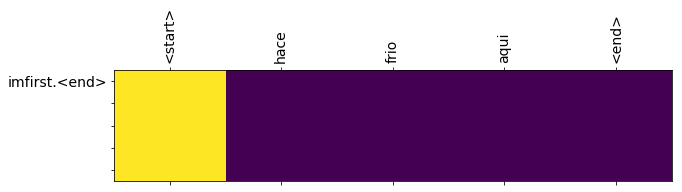

In [36]:
translate('hace frio aqui', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> esta es mi vida <end>
Predicted translation: imfirst.<end>


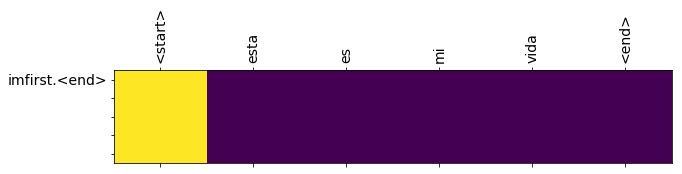

In [37]:
translate('esta es mi vida', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> ¿ estan en casa ? <end>
Predicted translation: imfirst?<end>


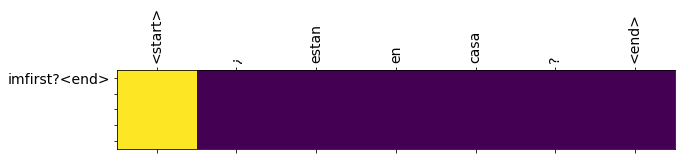

In [38]:
translate('¿estan en casa?', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)